# Attention : 
# Faire "File -> Save a copy in Drive" avant de commencer à modifier le notebook, sinon vos modifications ne seront pas sauvegardées.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 : 

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Partie 1 : Architecture VGG16

In [ ]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2022-01-13 14:01:35--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl [following]
--2022-01-13 14:01:35--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.003s  

2022-01-13 14:01:35 (12.2 MB/s) -

In [2]:
vgg16 = torchvision.models.vgg16(pretrained=True)

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
img = Image.open("cat.jpg")
img = img.resize((224, 224), Image.BILINEAR)
img.show()
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))[0:3]
img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x) # TODO calcul forward
y = y.detach().numpy() # transformation en array numpy
imagenet_classes[y.argmax()]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/yunfei/.cache/torch/hub/checkpoints/vgg16-397923af.pth


'Egyptian cat'

In [12]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
def show_grid(images, x_len=8, y_len=8):
    """ Show images in grid
        :param image: N, w, h
    """
    fig, axes = plt.subplots(x_len, y_len, figsize=(10, 10))
    axes = axes.flatten()
    for i in range(x_len * y_len):
        axes[i].imshow(images[i])
    plt.show()
        
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

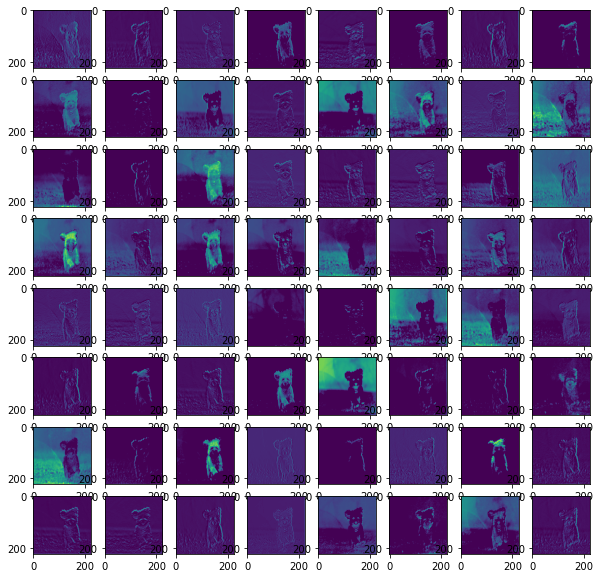

In [4]:
me = Image.open('dog.jpg')
vgg16.eval()
img = me
img = img.resize((224, 224), Image.BILINEAR)

img = np.array(img, dtype=np.float32)[:, :, 0:3] / 255
img = img.transpose((2, 0, 1))
# transform into a batch containing one image
img = np.expand_dims(img, 0)
x = torch.Tensor(img)

t = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

# Visualize feature maps
activation = {}

vgg16.features[0].register_forward_hook(get_activation('conv0'))
vgg16.features[1].register_forward_hook(get_activation('ReLU1'))
vgg16.features[2].register_forward_hook(get_activation('conv2'))
vgg16.features[3].register_forward_hook(get_activation('ReLU3'))
vgg16.features[4].register_forward_hook(get_activation('maxpool4'))
vgg16.features[28].register_forward_hook(get_activation('conv28'))

y = vgg16(t(x))

show_grid(activation['conv0'][0], x_len=8, y_len=8)

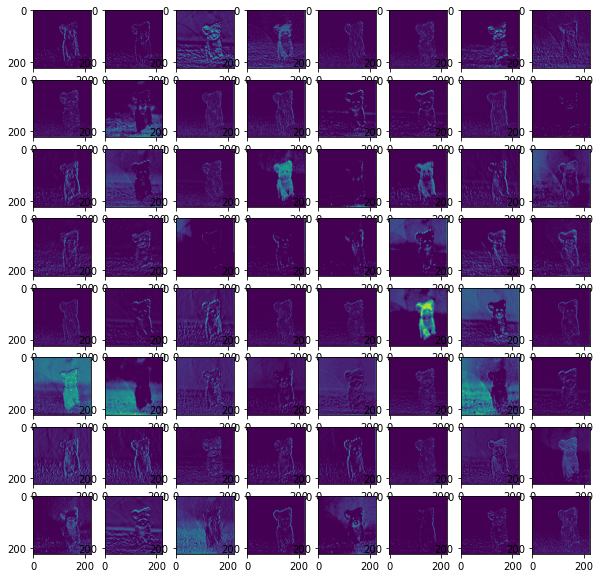

In [5]:
show_grid(activation['conv2'][0], x_len=8, y_len=8)

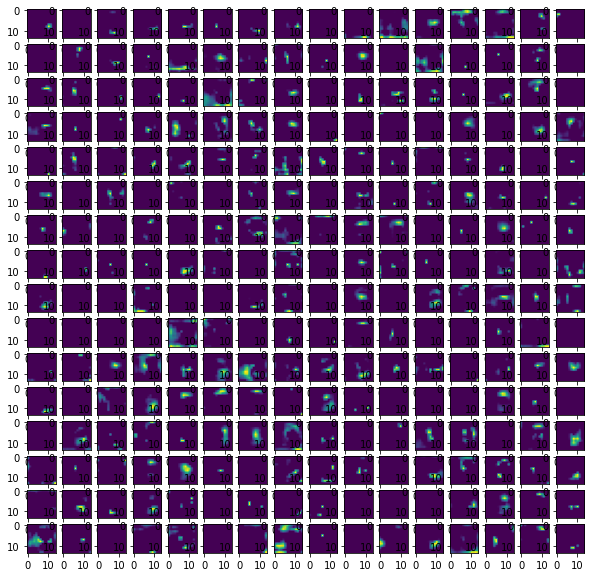

In [6]:
show_grid(activation['conv28'][0:256][0], x_len=16, y_len=16)

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [7]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!unzip 15ScenesData.zip

--2022-01-13 22:49:12--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/15ScenesData.zip [following]
--2022-01-13 22:49:13--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82,51M  17,5MB/s    in 4,5s    

2022-01-13 22:49:21 (18,5 MB/s) - ‘15Scen

In [8]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0042.jpg  image_0082.jpg  image_0124.jpg  image_0170.jpg
image_0004.jpg  image_0043.jpg  image_0084.jpg  image_0128.jpg  image_0175.jpg
image_0006.jpg  image_0047.jpg  image_0086.jpg  image_0130.jpg  image_0176.jpg
image_0007.jpg  image_0049.jpg  image_0087.jpg  image_0131.jpg  image_0180.jpg
image_0008.jpg  image_0050.jpg  image_0088.jpg  image_0134.jpg  image_0182.jpg
image_0011.jpg  image_0052.jpg  image_0090.jpg  image_0135.jpg  image_0189.jpg
image_0013.jpg  image_0053.jpg  image_0092.jpg  image_0138.jpg  image_0190.jpg
image_0014.jpg  image_0054.jpg  image_0093.jpg  image_0140.jpg  image_0191.jpg
image_0016.jpg  image_0056.jpg  image_0095.jpg  image_0141.jpg  image_0192.jpg
image_0017.jpg  image_0059.jpg  image_0096.jpg  image_0142.jpg  image_0195.jpg
image_0018.jpg  image_0060.jpg  image_0097.jpg  image_0144.jpg  image_0196.jpg
image_0019.jpg  image_0062.jpg  image_0098.jpg  image_0148.jpg  image_0200.jpg
image_0020.jpg  image_0063.jpg  image_0103.jpg  imag

In [ ]:
class VGG16relu17:
  pass  # A COMPLÉTER

In [ ]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.ToTensor()
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.ToTensor()
        ]))
    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices
    X = None
    y = None
    ####################
    ##      FIN        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire
        X = None
        y = None
        ####################
        ##      FIN        #
        ####################    

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = vgg16 
    ####################
    ##      FIN        #
    ####################      
    
    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0
    ####################
    ##      FIN        #
    ####################    
    print('Accuracy = %f' % accuracy)


In [ ]:
main("15SceneData", 8)